### Learning reaction types using a Random Forest classifier and more local difference fingerprints (AP3, MG2, TT)

In [1]:
import _pickle as cPickle
import gzip
from collections import defaultdict
import random
from sklearn.ensemble import RandomForestClassifier
import utilsFunctions
from pylab import rcParams

Choose some larger text size in the plots

In [2]:
rcParams.update({'font.size': 14})

In [3]:
dataDir = "../data/"

with open(dataDir+"reactionTypes_training_test_set_patent_data.pkl",'rb') as f:
    reaction_types = cPickle.load(f)
with open(dataDir+"names_rTypes_classes_superclasses_training_test_set_patent_data.pkl",'rb') as f:
    names_rTypes = cPickle.load(f)
# reaction_types = cPickle.load(file(dataDir+"reactionTypes_training_test_set_patent_data.pkl"))
# names_rTypes = cPickle.load(file(dataDir+"names_rTypes_classes_superclasses_training_test_set_patent_data.pkl"))

Load the different FPs (AP3, MG2, TT)

In [4]:
infile = gzip.open(dataDir+"transformationFPs_test_set_patent_data.pkl.gz", 'rb')

lineNo=0
fps=[]
idx=0
while 1:
    lineNo+=1
    try:
        lbl,cls,fp_AP3,fp_MG2,fp_TT = cPickle.load(infile)        
    except EOFError:
        break
    fps.append([idx,lbl,cls,fp_AP3,fp_MG2,fp_TT])
    idx+=1
    if not lineNo%10000:
        print("Done "+str(lineNo))

Done 10000
Done 20000
Done 30000
Done 40000


Split the FPs in training (20 %) and test data (80 %) per recation type (200, 800)

In [6]:
random.seed(0xd00f)
indices=list(range(len(fps)))
random.shuffle(indices)

nActive=200
fpsz=2048 # the FPs bit size for converting the FPs to a numpy array
#fpsz=4096
trainFps_fp_AP3=[]
trainFps_fp_MG2=[]
trainFps_fp_TT=[]
trainActs=[]
testFps_fp_AP3=[]
testFps_fp_MG2=[]
testFps_fp_TT=[]
testActs=[]

print('building fp collection')

rtypes=sorted(list(reaction_types))
for i,klass in enumerate(rtypes):
    actIds = [x for x in indices if fps[x][2]==klass]
    for x in actIds[:nActive]:
        trainFps_fp_AP3 += [utilsFunctions.fpToNP(fps[x][3],fpsz)]
        trainFps_fp_MG2 += [utilsFunctions.fpToNP(fps[x][4],fpsz)]
        trainFps_fp_TT += [utilsFunctions.fpToNP(fps[x][5],fpsz)]
    trainActs += [i]*nActive
    nTest=len(actIds)-nActive
    for x in actIds[nActive:]:
        testFps_fp_AP3 += [utilsFunctions.fpToNP(fps[x][3],fpsz)]
        testFps_fp_MG2 += [utilsFunctions.fpToNP(fps[x][4],fpsz)]
        testFps_fp_TT += [utilsFunctions.fpToNP(fps[x][5],fpsz)]
    testActs += [i]*nTest

building fp collection


Build the RF classifiers with max tree depth of 25

In [7]:
print('training models')
rf_cls_AP3 = RandomForestClassifier(n_estimators=200, max_depth=25,random_state=23,n_jobs=1)
result_rf_fp_AP3 = rf_cls_AP3.fit(trainFps_fp_AP3,trainActs)
rf_cls_MG2 = RandomForestClassifier(n_estimators=200, max_depth=25,random_state=23,n_jobs=1)
result_rf_fp_MG2 = rf_cls_MG2.fit(trainFps_fp_MG2,trainActs)
rf_cls_TT = RandomForestClassifier(n_estimators=200, max_depth=25,random_state=23,n_jobs=1)
result_rf_fp_TT = rf_cls_TT.fit(trainFps_fp_TT,trainActs)

training models


Evaluate the RF classifier using our test data

In [8]:
cmat_fp_AP3 = utilsFunctions.evaluateModel(result_rf_fp_AP3, testFps_fp_AP3, testActs, rtypes, names_rTypes)

ID  recall    prec F-score      reaction class
 0  0.9825  0.9740  0.9782     1.2.1 Aldehyde reductive amination
 1  0.9925  0.9211  0.9555     1.2.4 Eschweiler-Clarke methylation
 2  0.9838  0.9825  0.9831     1.2.5 Ketone reductive amination
 3  0.9775  0.9093  0.9422     1.3.6 Bromo N-arylation
 4  0.9762  0.9559  0.9660     1.3.7 Chloro N-arylation
 5  0.9912  0.9814  0.9863     1.3.8 Fluoro N-arylation
 6  0.9350  0.9627  0.9486     1.6.2 Bromo N-alkylation
 7  0.9287  0.9700  0.9489     1.6.4 Chloro N-alkylation
 8  0.9100  0.8698  0.8894     1.6.8 Iodo N-alkylation
 9  0.9750  0.9198  0.9466     1.7.4 Hydroxy to methoxy
10  0.7925  0.7905  0.7915     1.7.6 Methyl esterification
11  0.9387  0.9791  0.9585     1.7.7 Mitsunobu aryl ether synthesis
12  0.9250  0.9763  0.9499     1.7.9 Williamson ether synthesis
13  0.9938  0.9791  0.9864     1.8.5 Thioether synthesis
14  0.9263  0.9712  0.9482    10.1.1 Bromination
15  0.9688  0.9615  0.9651    10.1.2 Chlorination
16  0.9894  0.9408

Draw the confusion matix

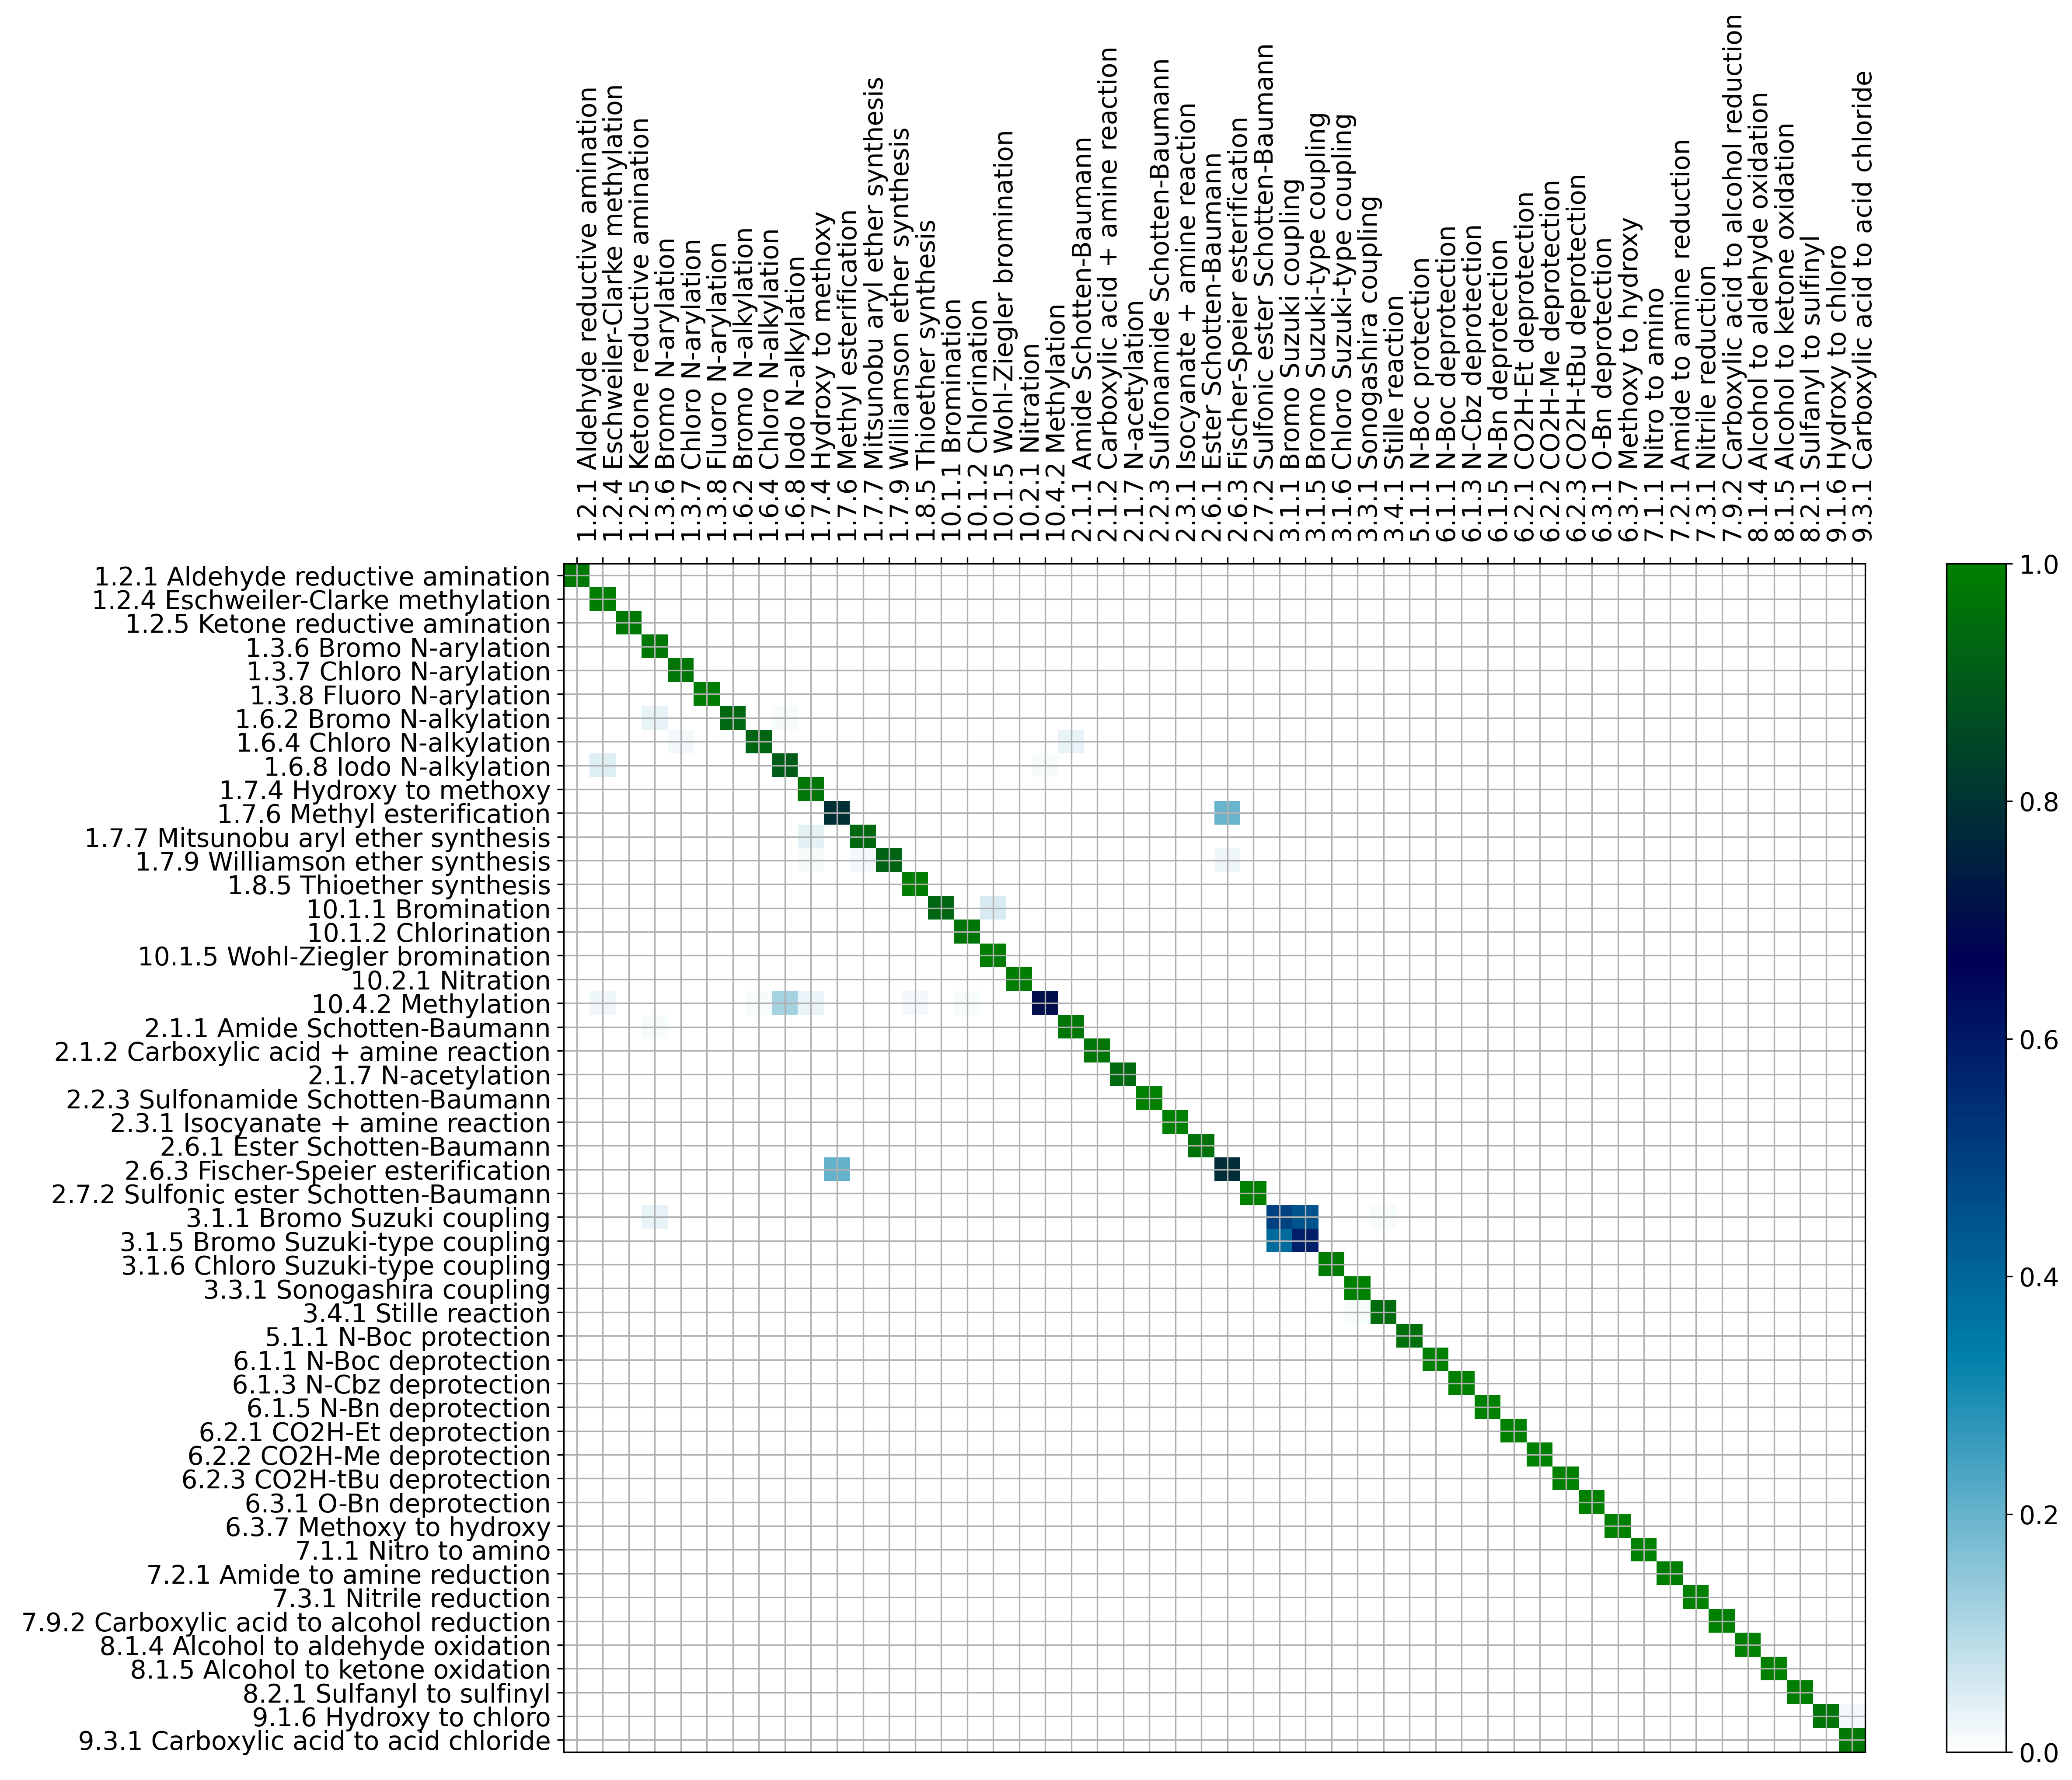

In [9]:
utilsFunctions.labelled_cmat(cmat_fp_AP3,rtypes,figsize=(16,12), labelExtras=names_rTypes)

In [10]:
cmat_fp_MG2 = utilsFunctions.evaluateModel(result_rf_fp_MG2, testFps_fp_MG2, testActs, rtypes, names_rTypes)

ID  recall    prec F-score      reaction class
 0  0.9875  0.9599  0.9735     1.2.1 Aldehyde reductive amination
 1  0.8413  0.9156  0.8769     1.2.4 Eschweiler-Clarke methylation
 2  0.9750  0.9762  0.9756     1.2.5 Ketone reductive amination
 3  0.9775  0.9243  0.9502     1.3.6 Bromo N-arylation
 4  0.9850  0.8965  0.9387     1.3.7 Chloro N-arylation
 5  0.9912  0.9577  0.9742     1.3.8 Fluoro N-arylation
 6  0.9387  0.9817  0.9597     1.6.2 Bromo N-alkylation
 7  0.8712  0.9587  0.9129     1.6.4 Chloro N-alkylation
 8  0.9175  0.7800  0.8432     1.6.8 Iodo N-alkylation
 9  0.9475  0.9244  0.9358     1.7.4 Hydroxy to methoxy
10  0.8013  0.7667  0.7836     1.7.6 Methyl esterification
11  0.9463  0.9818  0.9637     1.7.7 Mitsunobu aryl ether synthesis
12  0.9375  0.9778  0.9572     1.7.9 Williamson ether synthesis
13  0.9925  0.9555  0.9736     1.8.5 Thioether synthesis
14  0.9012  0.9717  0.9351    10.1.1 Bromination
15  0.9062  0.9201  0.9131    10.1.2 Chlorination
16  0.9881  0.9165

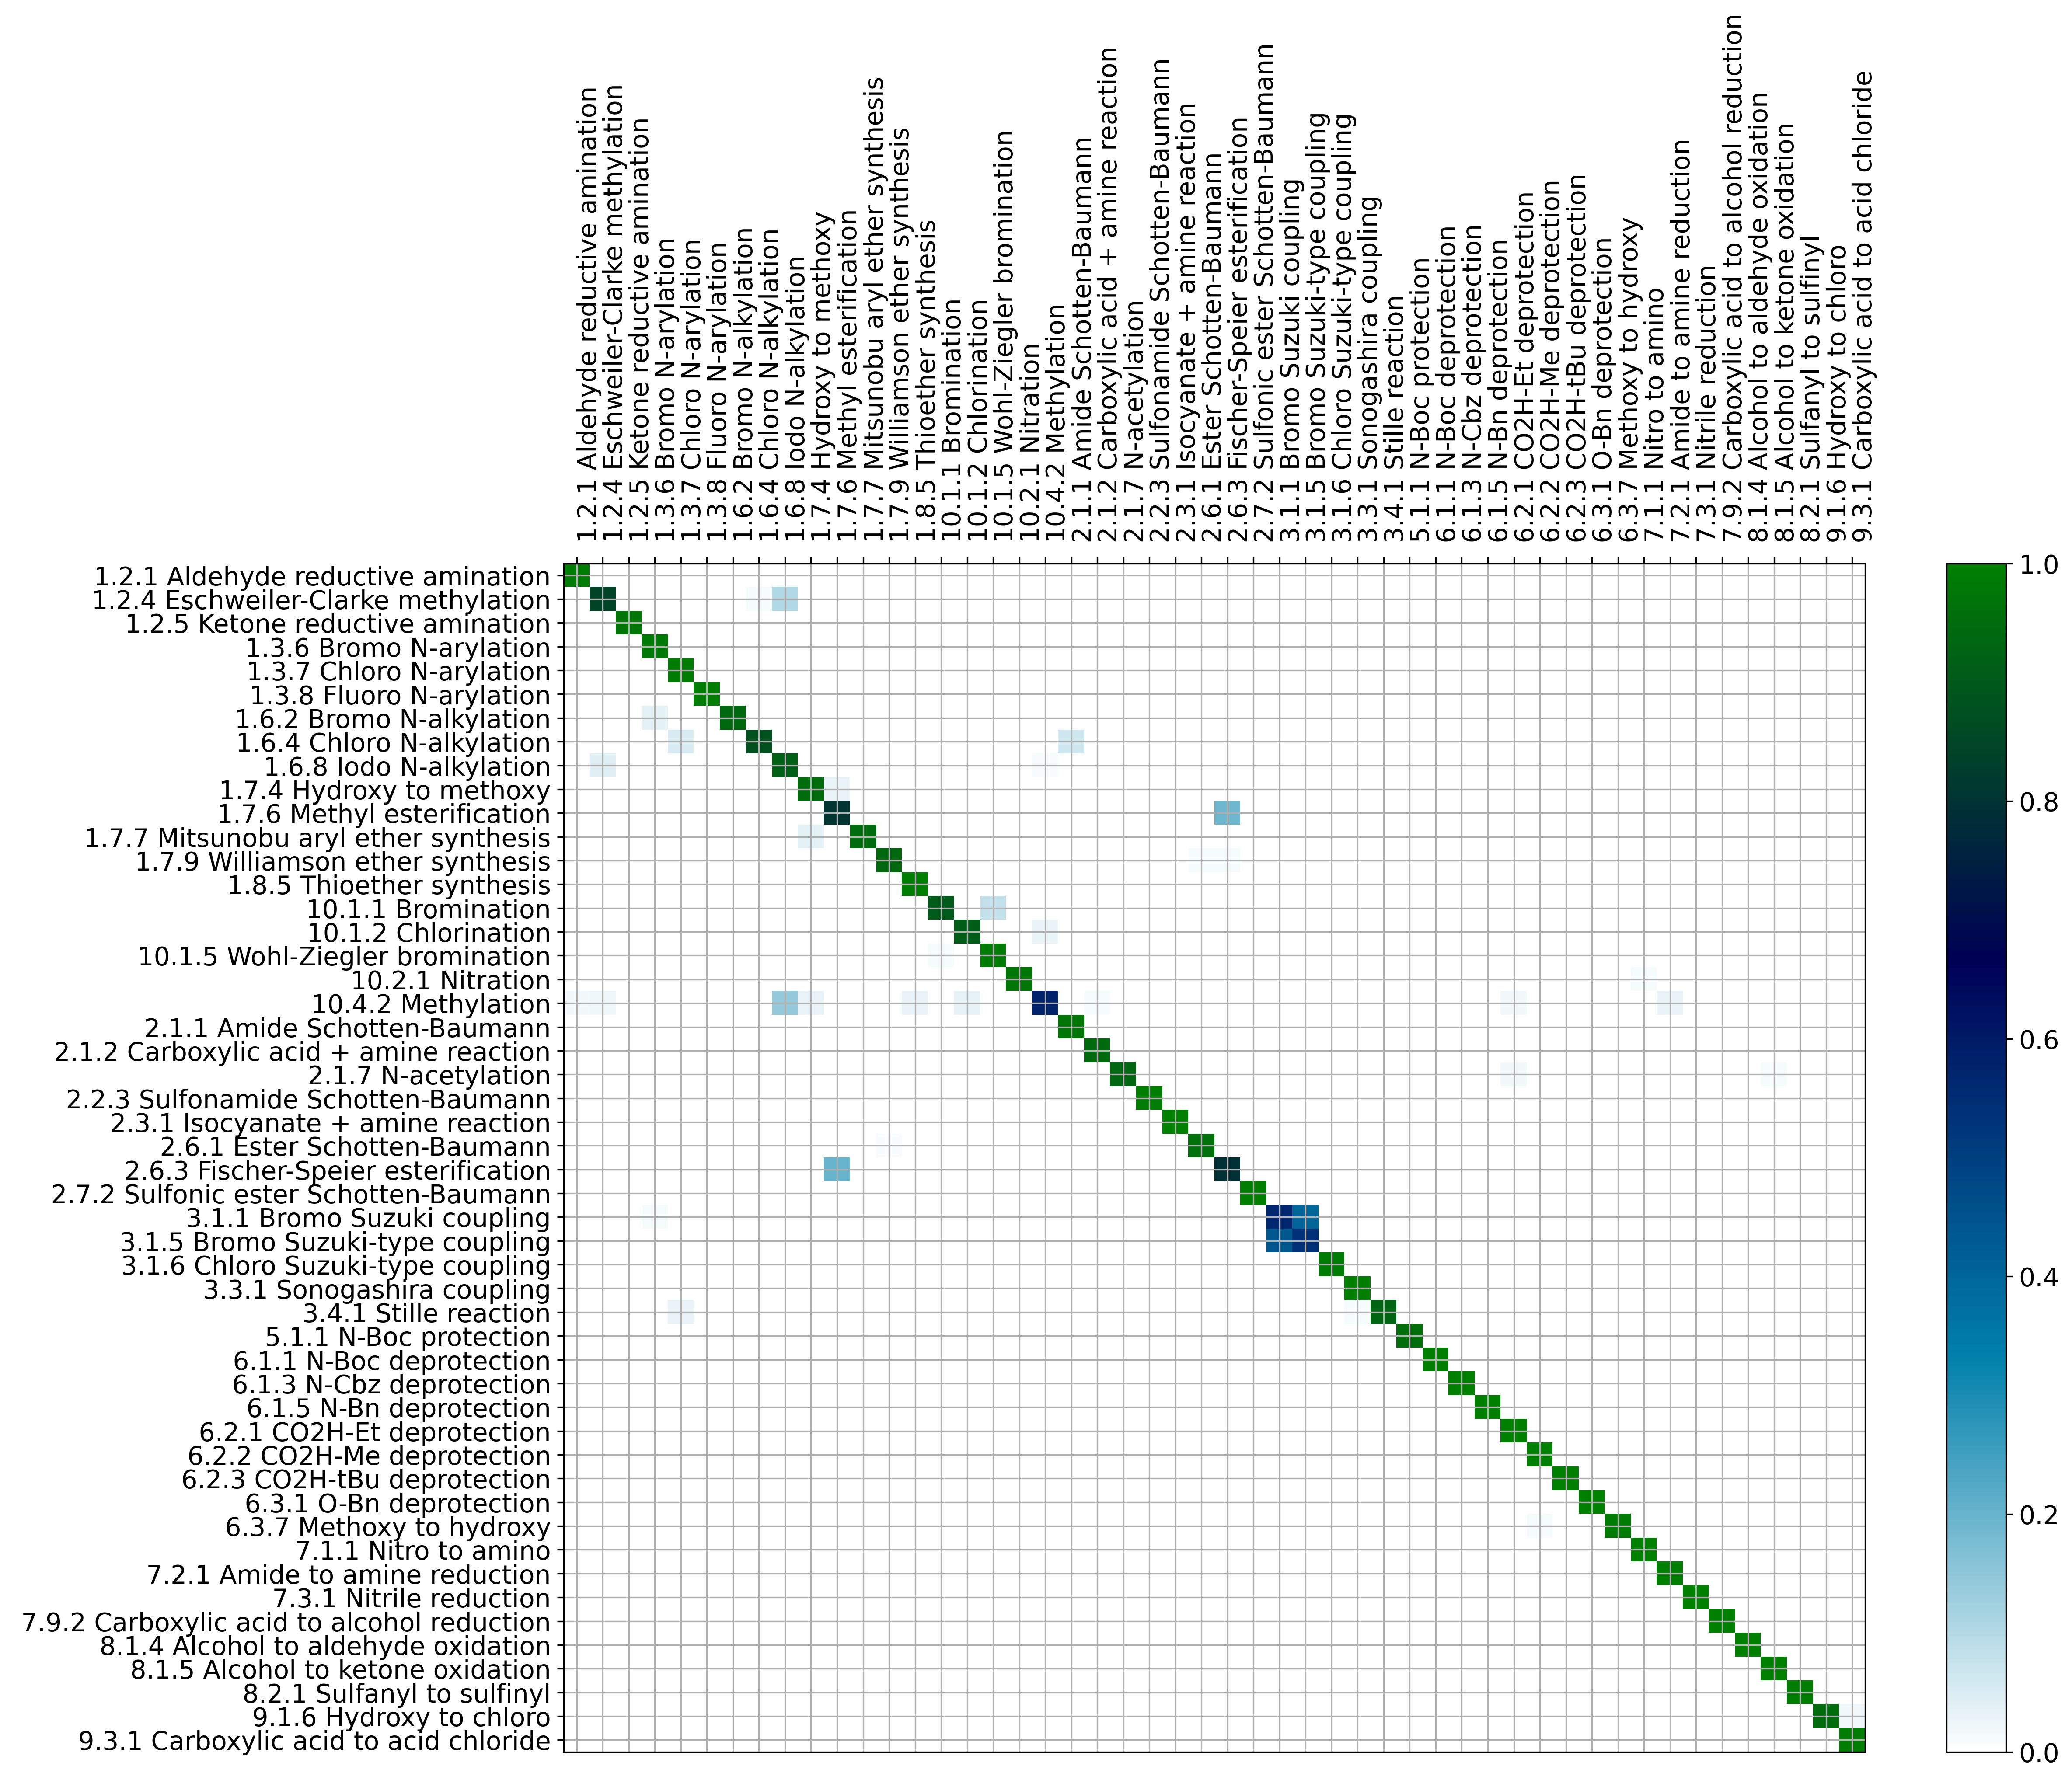

In [11]:
utilsFunctions.labelled_cmat(cmat_fp_MG2,rtypes,figsize=(16,12),labelExtras=names_rTypes)

In [12]:
cmat_fp_TT = utilsFunctions.evaluateModel(result_rf_fp_TT, testFps_fp_TT, testActs, rtypes, names_rTypes)

ID  recall    prec F-score      reaction class
 0  0.7775  0.8773  0.8244     1.2.1 Aldehyde reductive amination
 1  0.9237  0.6998  0.7963     1.2.4 Eschweiler-Clarke methylation
 2  0.8925  0.8302  0.8602     1.2.5 Ketone reductive amination
 3  0.8900  0.8386  0.8636     1.3.6 Bromo N-arylation
 4  0.9163  0.7985  0.8533     1.3.7 Chloro N-arylation
 5  0.9750  0.9187  0.9460     1.3.8 Fluoro N-arylation
 6  0.6212  0.5896  0.6050     1.6.2 Bromo N-alkylation
 7  0.5025  0.7628  0.6059     1.6.4 Chloro N-alkylation
 8  0.5275  0.6280  0.5734     1.6.8 Iodo N-alkylation
 9  0.7550  0.8377  0.7942     1.7.4 Hydroxy to methoxy
10  0.9525  0.6298  0.7582     1.7.6 Methyl esterification
11  0.7588  0.7987  0.7782     1.7.7 Mitsunobu aryl ether synthesis
12  0.5700  0.7808  0.6590     1.7.9 Williamson ether synthesis
13  0.9113  0.9000  0.9056     1.8.5 Thioether synthesis
14  0.8025  0.8747  0.8370    10.1.1 Bromination
15  0.6675  0.8153  0.7340    10.1.2 Chlorination
16  0.9046  0.9011

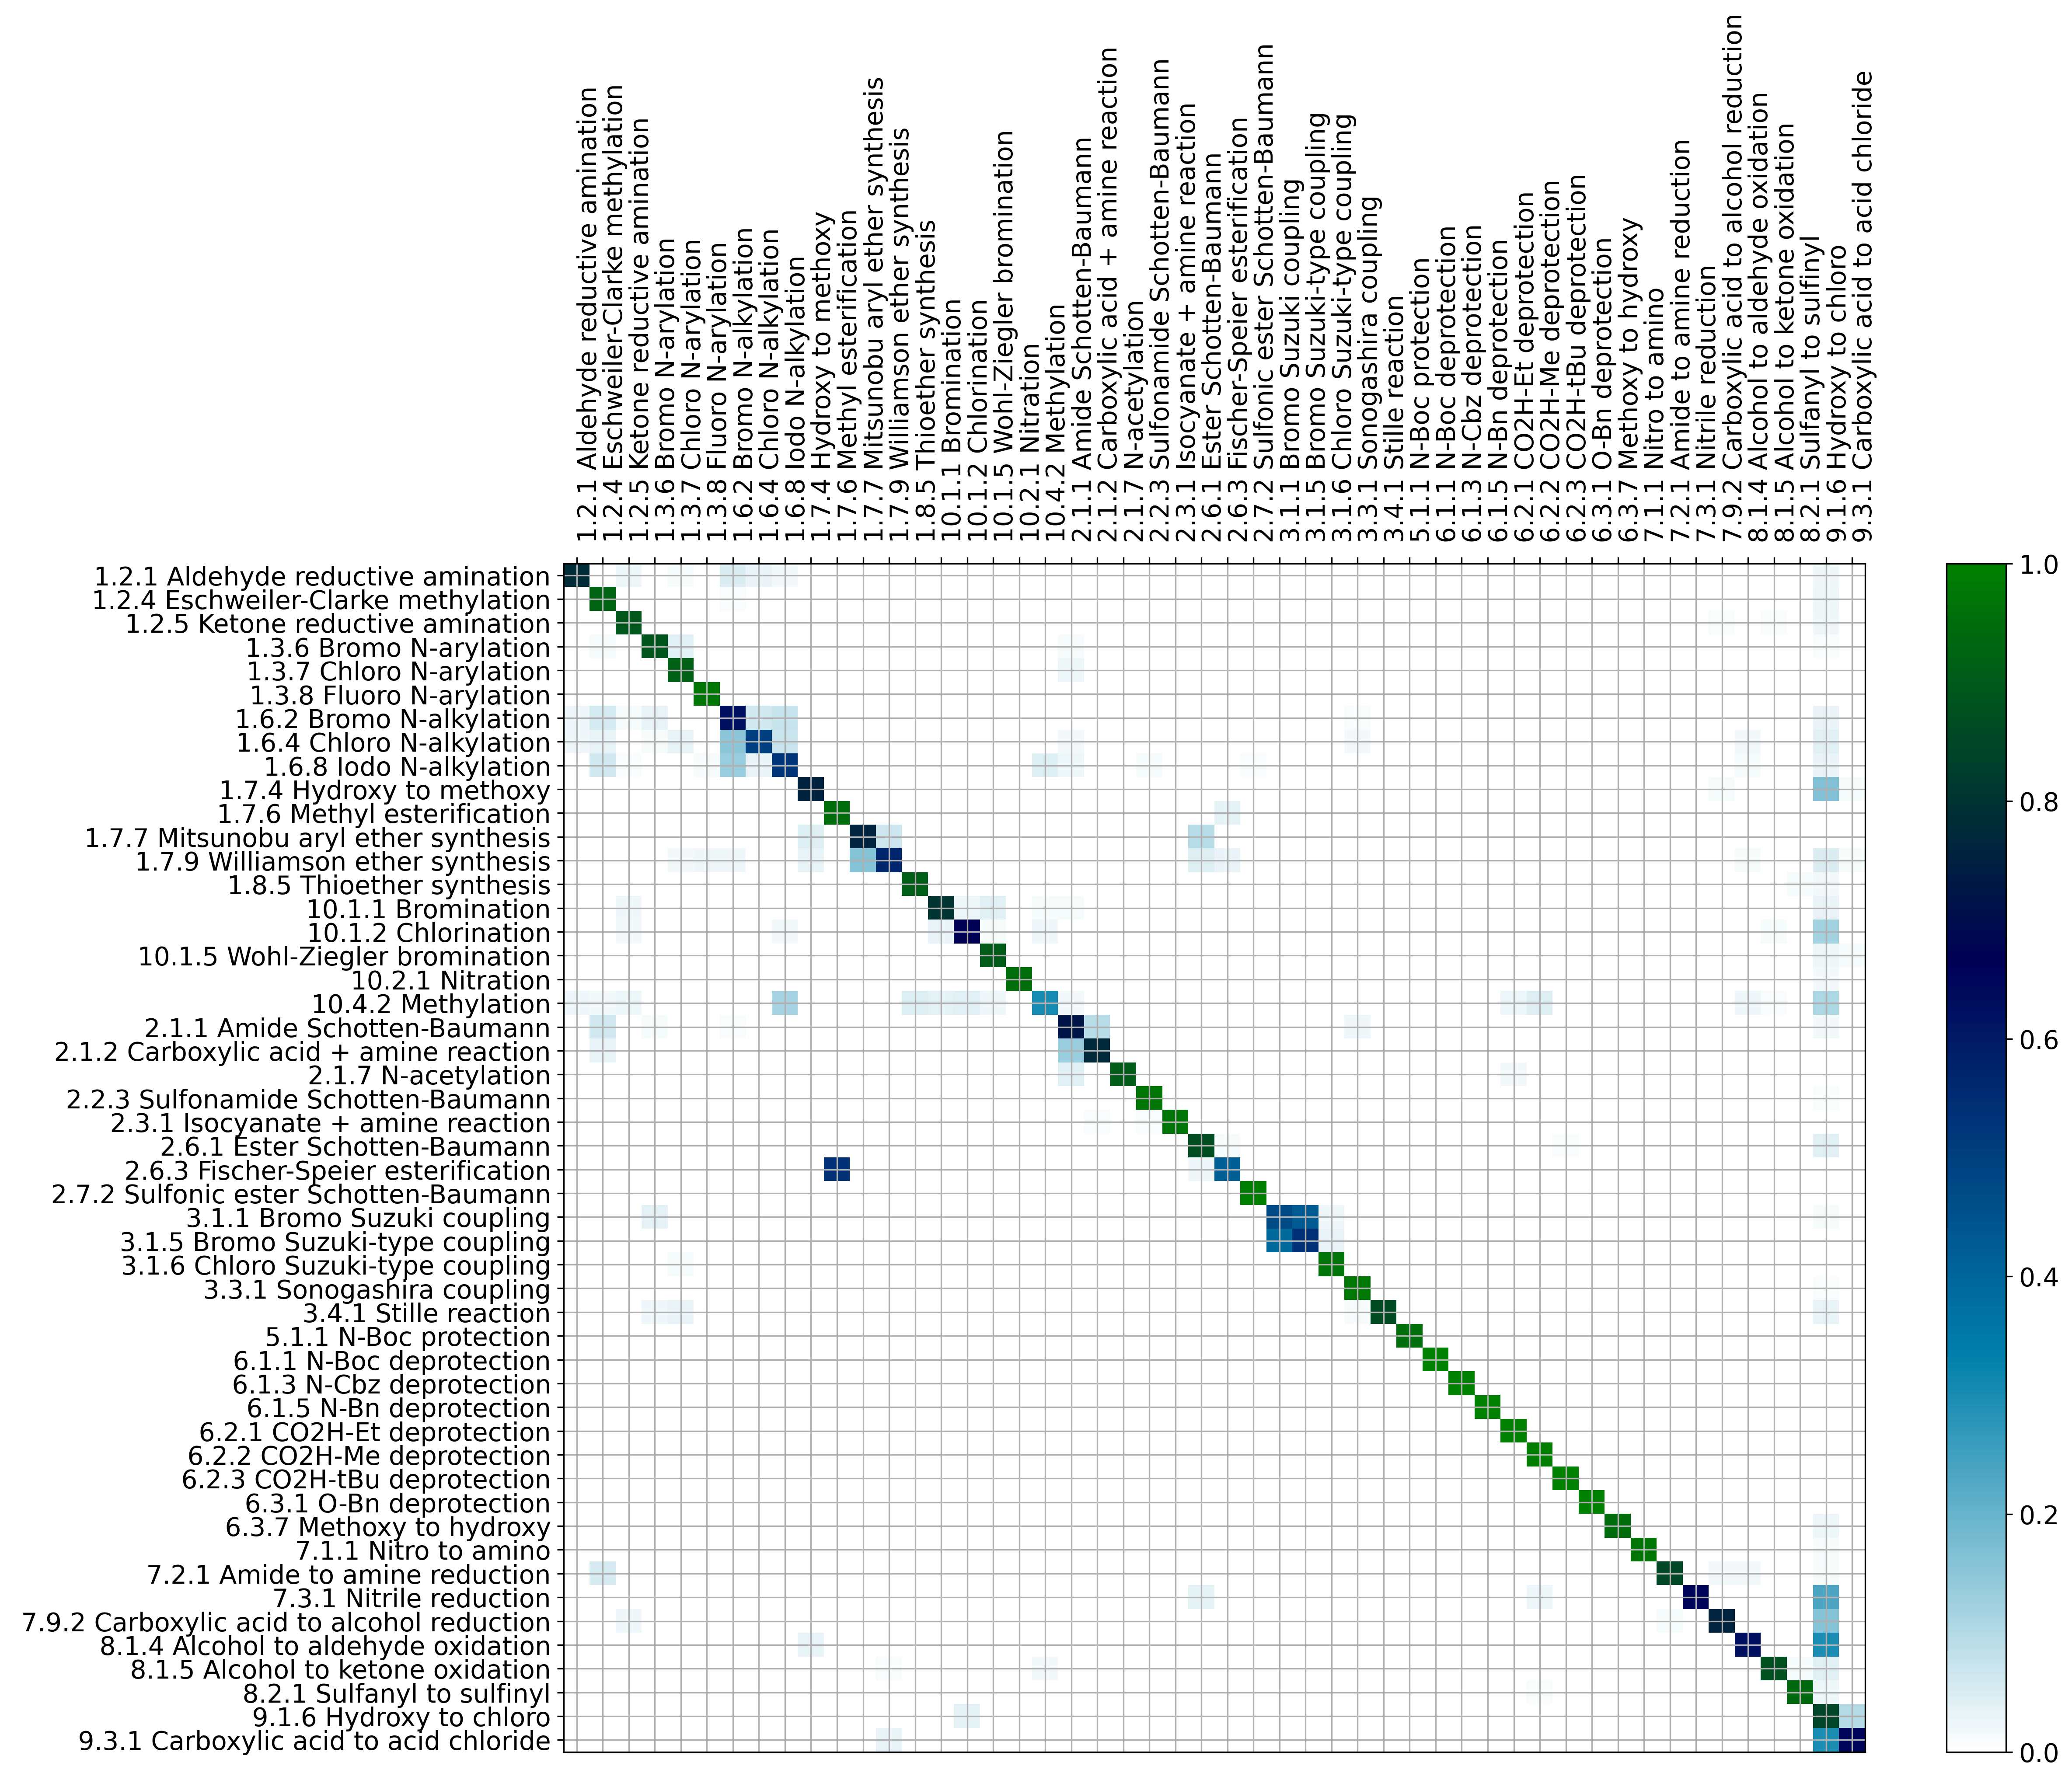

In [13]:
utilsFunctions.labelled_cmat(cmat_fp_TT,rtypes,figsize=(16,12),labelExtras=names_rTypes)